# PyTorch workflow

Let's start with an example PyTorch end-to-end workflow!


In [746]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [747]:
import torch
from torch import nn # nn contains all of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

#1. Data (preparing and loading)

Data can be almost anything...
* Excel spreadsheet
* images
* videos
* audio
* DNA
* text

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that representation

Let's create some *known* data using the linear regression formula.

We'll use a linear regressoin formula to make a straight line with *known* **parameters**.

In [748]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # added one extra dimension
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [749]:
len(X), len(y)

(50, 50)

### Split into train + test set

In [750]:
# create split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How can we visualize?

In [751]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

  # Predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show legends
  plt.legend(prop={"size": 14});

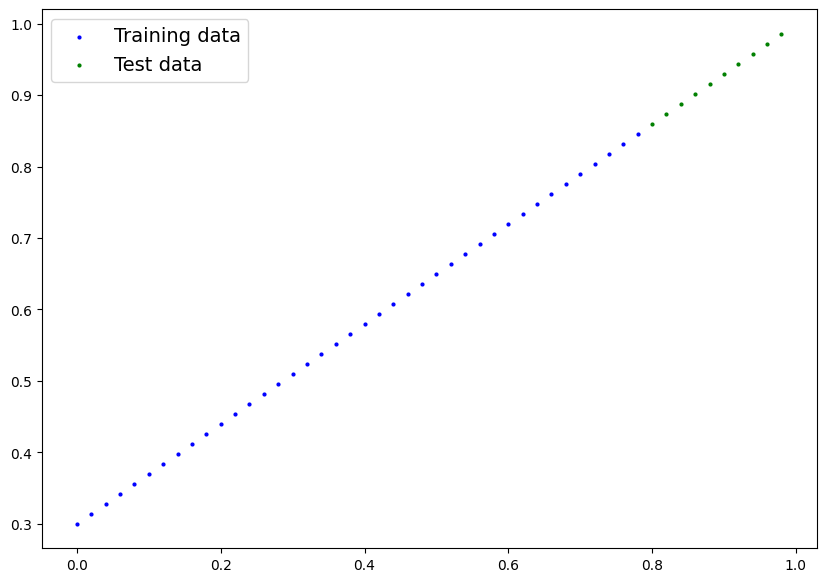

In [752]:
plot_predictions()

## 2. Build model

First model!

What the model does?
* Start with random weight and bias
* Look at training data and adjust random values closer to the actual ones

How?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [753]:
# Create linear regression model class
from torch import nn

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()

    # initializing model parameters
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight
                                            requires_grad=True, # can we use gradient descent?
                                            dtype=torch.float)) # PyTorch's favourite, default data type
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x:torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula



### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neual network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in Pytorch live, they will help with gradient descent
* def forward() - all nn.Module subckasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our model

Let's see what's inside...

We can check our model parameters or what's inside our model using ```.parameters()```

In [754]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [755]:
# List name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [756]:
weight, bias

(0.7, 0.3)

### Making prediction with `torch.inference_mode()`

When we pass data through our model, it goes through `forward()` method

In [757]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [758]:
# Make predictions
with torch.inference_mode(): # note there's not gradient function now as it is not needed when we are not training anything --> much faster!
  y_preds = model_0(X_test)

# Also torch_no_grad is similar, but inference_mode is preferred !!!
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [759]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

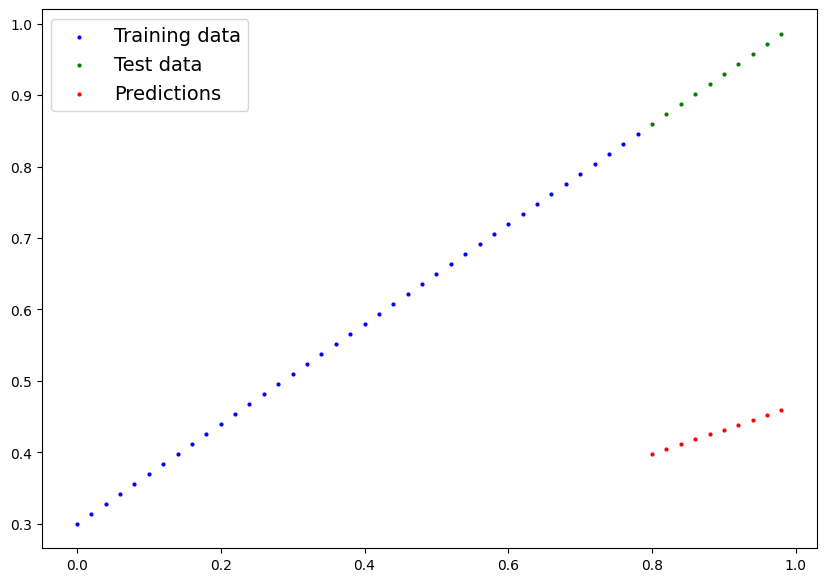

In [760]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea is for a model to move from *unknown* parameters (which may be random) to *known* ones!

Or in other words from a poor representation to a better one of the data.

One way to measure how poor or how wrong the predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal ones --> the lower the better!
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters to improve the loss function.
  * Needs 2 parameters: parameters to optimize and a learning rate!

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [761]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [762]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [763]:
# Setup a loss function (which one to use is specific for a problem)
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), # what to optimize?
                            lr=0.01) # learning rate (the most important hyperparameter?)

### Building a training loop (and a testing loop) in PyTorch

A couple of things needed:
0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's ```forward()```) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [764]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter as we've set ourselves)
epochs = 200

# Track model values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode (the default mode)
  model_0.train() # train mode sets all params that require gradients to require gradients

  # 1. Forward pass on training data
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the opimizer (perform gradient descent) to update model's parameters based on backpropagation
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop


  ### Testing
  model_0.eval() # turns off some settings not needed in testing
  with torch.inference_mode(): # turns off gradient tracking etc behind the scenes
  # with toch.no_grad():  # works also, but older version, not that fast

    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Test: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Test: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Test: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Test: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Test: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

Text(0.5, 0, 'Epoch')

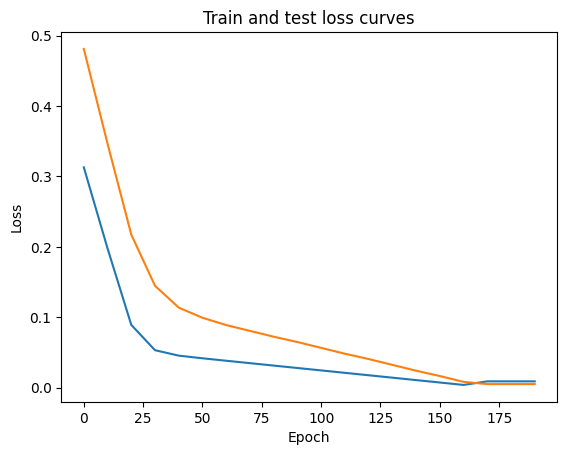

In [765]:
import numpy as np

# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [766]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [767]:
weight, bias

(0.7, 0.3)

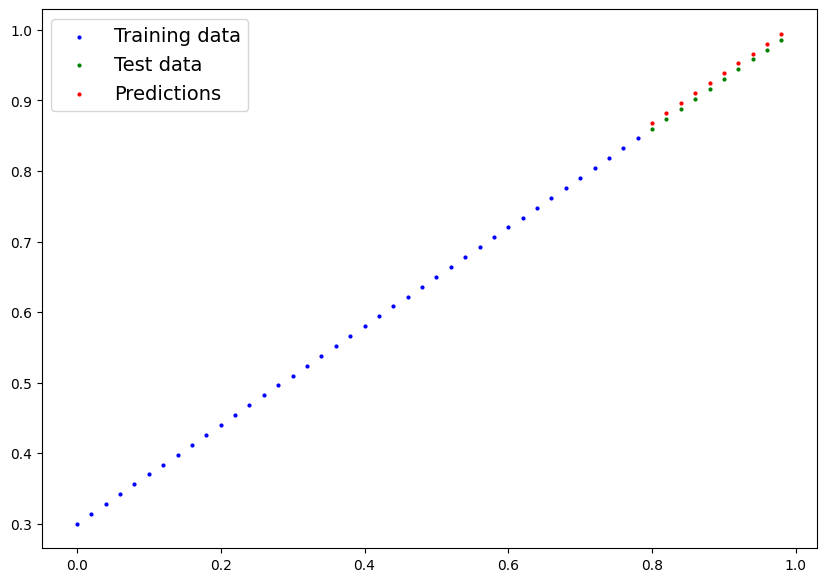

In [768]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

3 main methods for saving and loading models in PyTorch:

1. `torch.save()` - allows to save a PyTorch object in Python's pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

In [769]:
# Saving our model
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # usually .pth is the type in which model is saved
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [770]:
!ls -l models

total 12
-rw-r--r-- 1 root root 1680 Jun 13 14:56 01_pytorch_workflow_model_0.pth
-rw-r--r-- 1 root root 1744 Jun 13 14:55 01_pytorch_workflow_model_1.pth
-rw-r--r-- 1 root root 1590 Jun 13 14:50 linreg_model.pth


## Loading a PyTorch model

Since we saved our model's `state dict()` and not the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that!

In [771]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [772]:
# To load in a saved state_dict we have to instantate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [773]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [774]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [775]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together

Let's go through the steps above altogether!


In [776]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

Create device-agnostic code.

This means if we've got an access to a GPU, our code will use it. Otherwise, normal CPU is used.

In [777]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 6.1 Data

In [778]:
# Create some data using the linear regression formula y = w * X + b
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [779]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

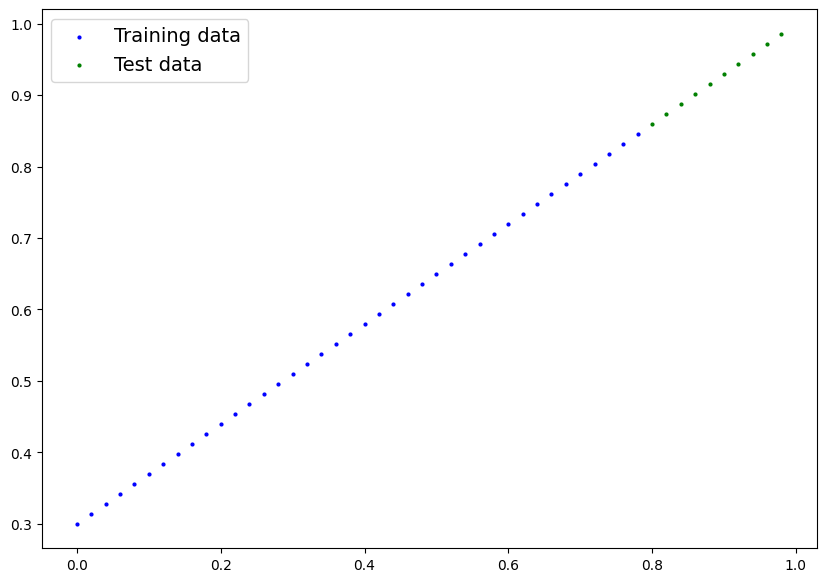

In [780]:
# Plot the data
# Note: if not having the plot_predictions() loaded, error

plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a Linear PyTorch model

In [781]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters (also called linear transform, probing layer, fully connected layer...)
    self.linear_layer = nn.Linear(in_features=1, # for each input X, one output 1!
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor: # again, just sayin' that x is usually a Tensor and we return a Tensor
    return self.linear_layer(x) # now linear regression is done by PyTorch !

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [782]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [783]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [784]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [785]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [786]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data as well)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [787]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [788]:
weight, bias

(0.7, 0.3)

## 6.4 Making and evaluating predictions

In [789]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

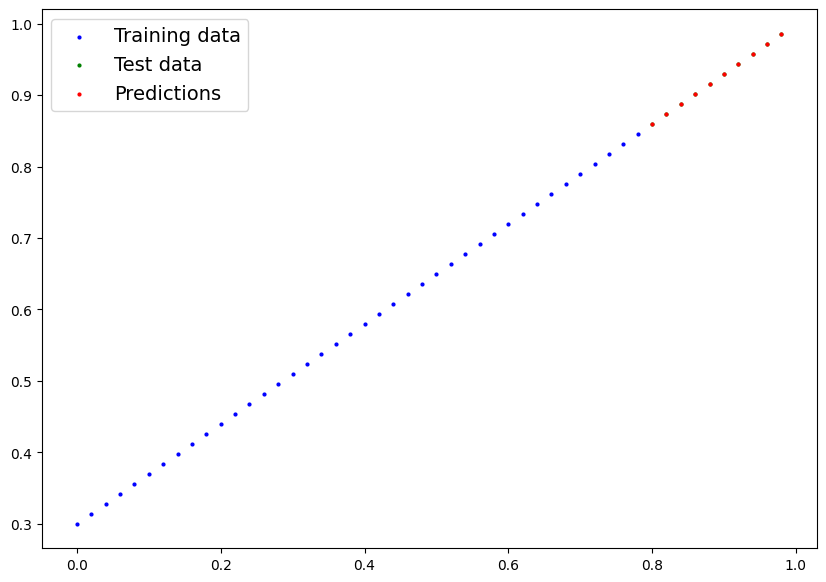

In [790]:
# Check the results visually
plot_predictions(predictions=y_preds.cpu())

## 6.5 Saving & loading a trained model

In [791]:
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [792]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [793]:
# Load a PyTorch model

# Create a new instance of linear regression V2 model
loaded_model_1 = LinearRegressionModelV2()

# Load the saved state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to the device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [794]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [795]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [796]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

# Exercises

In [797]:
# 1

weight = 0.3
bias = 0.9
X = torch.arange(0,5,0.25).unsqueeze(dim=1)
y = weight * X + bias

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [798]:
# 2
class LinRegModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linearLayer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.tensor) -> torch.Tensor:
    return self.linearLayer(x)

linModel = LinRegModel()
linModel.state_dict()


OrderedDict([('linearLayer.weight', tensor([[-0.2343]])),
             ('linearLayer.bias', tensor([0.9186]))])

In [799]:
# 3
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=linModel.parameters(), lr=0.01)

epochs = 300
device = "cuda" if torch.cuda.is_available() else "cpu"
linModel.to(device)
print(f"Using device: {device}")

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  linModel.train()
  y_pred = linModel(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 20 == 0:
    linModel.eval()
    with torch.inference_mode():
      y_test_pred = linModel.forward(X_test)
      loss = loss_fn(y_test_pred, y_test)

      print(f"Epoch: {epoch}, loss: {loss}")

Using device: cuda
Epoch: 0, loss: 0.7162013053894043
Epoch: 20, loss: 0.11077438294887543
Epoch: 40, loss: 0.0674346536397934
Epoch: 60, loss: 0.037498727440834045
Epoch: 80, loss: 0.025584757328033447
Epoch: 100, loss: 0.02128787338733673
Epoch: 120, loss: 0.02128787338733673
Epoch: 140, loss: 0.02128787338733673
Epoch: 160, loss: 0.02128787338733673
Epoch: 180, loss: 0.02128787338733673
Epoch: 200, loss: 0.02128787338733673
Epoch: 220, loss: 0.02128787338733673
Epoch: 240, loss: 0.02128787338733673
Epoch: 260, loss: 0.02128787338733673
Epoch: 280, loss: 0.02128787338733673


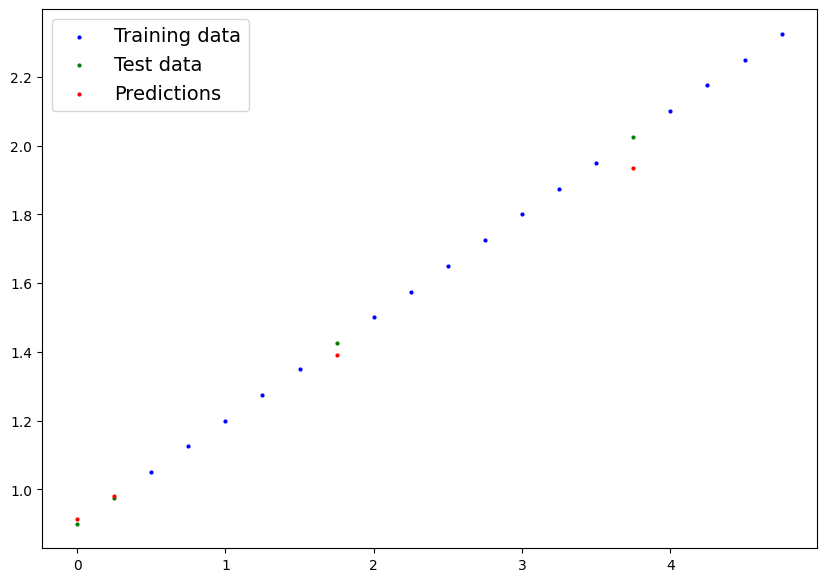

In [802]:
# 4
linModel.eval()
with torch.inference_mode():
  y_test_pred = linModel(X_test)

plot_predictions(train_data=X_train.cpu(),
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu(),
                 predictions=y_test_pred.cpu())

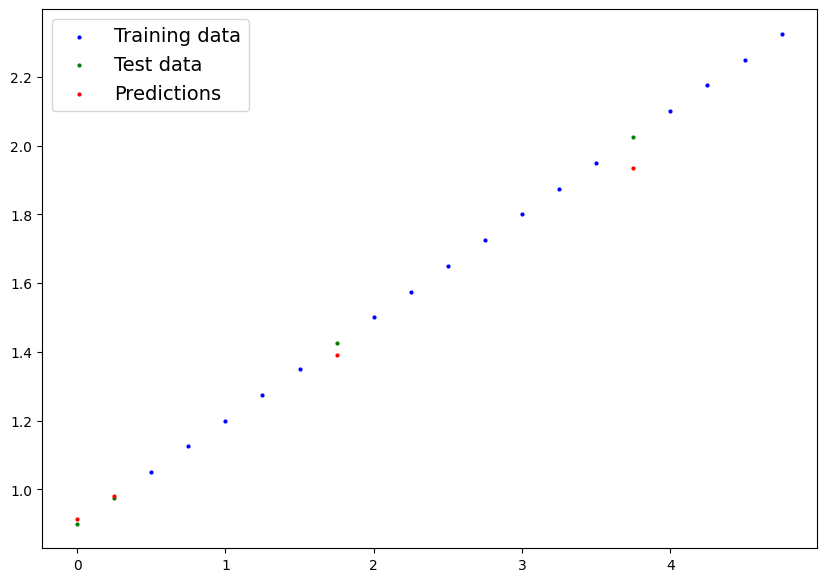

In [807]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True, parents=True)

MODEL_NAME = "linreg_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=linModel.state_dict(),
           f=MODEL_SAVE_PATH)

linModel_loaded = LinRegModel()
linModel_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
linModel_loaded.to(device)

linModel_loaded.eval()
with torch.inference_mode():
  y_preds_new = linModel_loaded(X_test)

plot_predictions(train_data=X_train.cpu(),
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu(),
                 predictions=y_preds_new.cpu())